# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
n = 4  # number of variables

number_formulas_load = 2**(2**(4)) #manually specify number of formulas for loading file (must be the same as used in the previous notebook)

number_of_lambda_nets = number_formulas_load #use this parameter to select how many lambda nets should be generated

#lambda net specifications 
batch_size = 2**n
epochs = 200
lambda_network_layers = [(2**n) * 5]
optimizer='SGD'

                               
each_epochs_save = 5 #specifies the number of epochs to checkpoint lambda network weights, if None no checkpointing

n_jobs = -3 #joblib multiporcessing kernels



In [2]:
##############DO NOT CHANGE###################
RANDOM_SEED = 42

all_formulas_included = True if (number_of_lambda_nets == 2**(2**(4)) and n ==4) else False #can be set true if n=4 (if all possible functions should be included in dataset)

layers_str = ''.join([str(neurons) + '-' for neurons in lambda_network_layers])

seed_method = True
shuffle = True

if number_of_lambda_nets==2**(2**(n)) and all_formulas_included:
    data_size_string = '_all'  
elif number_of_lambda_nets==2**(2**(n)) and not all_formulas_included:
    data_size_string = '_' + str(number_formulas_load)
elif not number_of_lambda_nets==2**(2**(n)) and all_formulas_included:
    data_size_string = '_'  + str(number_of_lambda_nets)
elif not number_of_lambda_nets==2**(2**(n)) and not all_formulas_included:
    data_size_string = '_' + str(number_formulas_load)

structure = '_' + layers_str + str(epochs) + 'e' + str(batch_size) + 'b'

if seed_method and shuffle:
    seed_shuffle_string = '_shuffleSeedMethod'
elif not seed_method and shuffle:
    seed_shuffle_string = '_shuffleNoSeedMethod'
elif seed_method and not shuffle:
    seed_shuffle_string = '_noShuffleSeedMethod'
elif not seed_method and not shuffle:
    seed_shuffle_string = '_noShuffleNoSeedMethod'
    
filename = seed_shuffle_string + structure + str(RANDOM_SEED)

variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

use_gpu = False
if use_gpu:
    gpu_numbers = '0'
else:
    gpu_numbers = ''

print('Variables: ' + str(n) + ' (' + variables + ')')
print('Loaded Expressions: ' + str(number_formulas_load))
print('Lambda-Models to Train: ' + str(number_of_lambda_nets))
   
      

Variables: 5 (abcde)
Loaded Expressions: 333
Lambda-Models to Train: 333


## Imports

In [3]:
import ttg
from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
from prettytable import PrettyTable
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import math 

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers
import shutil

from joblib import Parallel, delayed
import keras.backend as K


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, mean_squared_error

from IPython.display import Image

from livelossplot.keras import PlotLossesCallback

np.set_printoptions(suppress=True)

import tensorflow as tf
import random 
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau




Using TensorFlow backend.


## Utility functions

In [4]:
def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)
def chunks(lst, chunksize):
    for i in range(0, len(lst), chunksize):
        yield lst[i:i + chunksize]

## Loss/Error functions

In [5]:
def accuracy_complete(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
        
    if np.array_equal(y_true, y_pred):
        return 1

    return 0


def accuracy_complete_with_threshold(y_true, y_pred, threshold):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
        
    counter_total = 0
    counter_correct = 0
    y_true_entry_treshold = []
    y_pred_entry_treshold = []
    
    for value_true, value_pred in zip(y_true, y_pred):
        if value_pred < threshold or value_pred > (1-threshold):
            y_true_entry_treshold.append(value_true)
            y_pred_entry_treshold.append(value_pred)
    y_true_entry_treshold = np.array(y_true_entry_treshold)
    y_pred_entry_treshold = np.around(np.array(y_pred_entry_treshold)).astype('int') 
            
    if np.array_equal(y_true_entry_treshold, y_pred_entry_treshold):
        return 1, len(y_pred_entry_treshold)
           
            
    return 0, len(y_pred_entry_treshold)

def accuracy_minterm_with_threshold(y_true, y_pred, threshold):
    
    '''
    y_true = true values that are 0 or 1
    y_pred = proba values that are float numbers
    treshhold = treshhold where we round
    '''
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    accuracy_final = 0
   
    counter_ele = 0
    normalization_counter = 0
    accuracy_tmp = 0

    for pred in y_pred:
        if pred < threshold or pred > (1-threshold):
            accuracy_tmp += (np.around(pred).astype('int')) == y_true[counter_ele]
            normalization_counter += 1
        counter_ele += 1
        
    accuracy_final = accuracy_tmp / normalization_counter
    
    
    return accuracy_final, len(pred)


def accuracy_minterm(y_true, y_pred):
    
    '''
    y_true = true values that are 0 or 1
    y_pred = proba values that are float numbers
    treshhold = treshhold where we round
    '''
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
        
    accuracy_final = 0
    counter_ele = 0
    accuracy_tmp = 0

    for pred in y_pred:
        accuracy_tmp += (np.around(pred).astype('int')) == y_true[counter_ele]
        counter_ele += 1
        #Normalize the accuracy
    accuracy_final = accuracy_tmp / counter_ele
    
    return accuracy_final
    
    

def root_mean_squared_error_keras(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
        
    if tf.is_tensor(y_true):
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    else:
        y_true = tf.convert_to_tensor(y_true)
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    if tf.is_tensor(y_pred):
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
    else:
        y_pred = tf.convert_to_tensor(y_pred)
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
            
            
    return tf.math.sqrt(K.mean(K.square(y_pred - y_true))) 


def mean_absolute_percentage_error_keras(y_true, y_pred, epsilon=10e-3): 
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
        
    if tf.is_tensor(y_true):
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    else:
        y_true = tf.convert_to_tensor(y_true, dtype =  tf.float32)
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    if tf.is_tensor(y_pred):
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
    else:
        y_pred = tf.convert_to_tensor(y_pred, dtype =  tf.float32)
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
        
    epsilon = tf.convert_to_tensor(epsilon)
    epsilon = tf.dtypes.cast(epsilon, tf.float32)
        
    return tf.reduce_mean(tf.abs(tf.divide(tf.subtract(y_pred, y_true),(y_true + epsilon))))

def huber_loss_delta_set(y_true, y_pred):
    return keras.losses.huber_loss(y_true, y_pred, delta=0.3)

In [6]:
def relative_absolute_average_error(y_true, y_pred, epsilon=10e-7):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
       
    #error value calculation    
    result = np.sum(np.abs(y_true-y_pred))/(y_true.shape[0]*np.std(y_true)+epsilon) #correct STD?
    
    return result


def relative_maximum_average_error(y_true, y_pred, epsilon=10e-7):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    #error value calculation    
    result = np.max(y_true-y_pred)/(np.std(y_true)+epsilon) #correct STD?
    
    return result

## Load Data

In [7]:
if all_formulas_included:
    path = './data/pickled_expression_lists/total_expressions_length_' + str(n) + '_variables_' + str(n) + '_df.pkl'

else:
    path = './data/pickled_expression_lists/sample' + str(number_formulas_load) +  '_expressions_length_' + str(n) + '_variables_' + str(n) + '_df.pkl'


with open(path, 'rb') as f:
    list_of_tables_pandas = pickle.load(f)

    

In [8]:
X_train_list = []
y_train_list = []
zhegalkin_polynoms = []

if shuffle:
    for df in tqdm(random.sample(list_of_tables_pandas, number_of_lambda_nets)):
        X_train = df[[variable for variable in variables[:n]]]
        zhegalkin_polynoms.append(df.iloc[:,-1:])
        y_train = df.drop([variable for variable in variables[:n]], axis=1)
        y_train = y_train.drop(y_train.columns[-1], axis = 1)
        X_train_list.append(X_train)
        y_train_list.append(y_train)
else:
    for df in tqdm(list_of_tables_pandas[:number_of_lambda_nets]):
        X_train = df[[variable for variable in variables[:n]]]
        zhegalkin_polynoms.append(df.iloc[:,-1:])
        y_train = df.drop([variable for variable in variables[:n]], axis=1)
        y_train = y_train.drop(y_train.columns[-1], axis = 1)
        X_train_list.append(X_train)
        y_train_list.append(y_train)

In [9]:
#clear files
try:
    # Create target Directory
    os.mkdir('./data/weights/weights_formula_' + str(n) + data_size_string + filename)
except FileExistsError:
    if each_epochs_save != None:
            for i in range(epochs//each_epochs_save):    

                path = './data/weights/weights_formula_' + str(n) + data_size_string + filename + '/weights_with_y' + '_formula_' + str(n) + data_size_string + '_epoch_' + str((i+1)*each_epochs_save).zfill(3)  + filename + '.txt'

                with open(path, 'wt') as text_file:
                    text_file.truncate()    
    else:
        path = './data/weights/weights_formula_' + str(n) + data_size_string + filename + '/weights_with_y' + str(n) + data_size_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'

        with open(path, 'wt') as text_file:
            text_file.truncate()
                

## Data Inspection

In [10]:
list_of_tables_pandas[4].shape

(32, 7)

In [11]:
list_of_tables_pandas[8]

,a,b,c,d,e,~a and ~b and ~c and ~d and ~e or ~a and ~b and c and ~d and ~e or ~a and ~b and c and d and ~e or ~a and b and ~c and ~d and e or ~a and b and ~c and d and ~e or ~a and b and c and ~d and ~e or ~a and b and c and ~d and e or ~a and b and c and d and e or a and ~b and ~c and d and ~e or a and ~b and c and d and ~e or a and ~b and c and d and e or a and b and ~c and ~d and e or a and b and ~c and d and e or a and b and c and ~d and ~e or a and b and c and ~d and e,a xor b xor c xor d xor (a & d) xor (a & e) xor (c & d) xor (c & e) xor (a & b & c) xor (a & c & e) xor (a & d & e) xor (a & b & c & d) xor (a & b & c & e) xor (a & b & d & e) xor (a & c & d & e) xor (b & c & d & e) xor (a & b & c & d & e)
1,1,1,1,1,1,0,1
2,1,1,1,1,0,0,1
3,1,1,1,0,1,1,1
4,1,1,1,0,0,1,1
5,1,1,0,1,1,1,1
6,1,1,0,1,0,0,1
7,1,1,0,0,1,1,1
8,1,1,0,0,0,0,0
9,1,0,1,1,1,1,1
10,1,0,1,1,0,1,1


## Lambda Network Training + Weigh/Bias saving

In [12]:
def train_nn(X_train, y_train, formula, zhegalkin_polynom, callbacks=None, return_history=True, each_epochs_save=None, printing=False, return_model=False):
   
    'Define the score list: It is filled with one dict if each_epochs_save == None or equals the number set'
    result_dict_list = dict()

    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if int(tf.__version__[0]) >= 2:
        tf.random.set_seed(RANDOM_SEED)
    else:
        tf.set_random_seed(RANDOM_SEED)    
        
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.values
        
    model = Sequential()

    
    model.add(Dense(lambda_network_layers[0], activation='relu', input_dim=X_train.shape[1])) #1024

    for neurons in lambda_network_layers[1:]:
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    
    

    #adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95)
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'mse', root_mean_squared_error_keras])
    
    weights = []
    preds = []
    if each_epochs_save == None:
        model_history = model.fit(X_train, 
                      y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      callbacks=callbacks,
                      verbose=0,
                      workers=0)
        weights.append(model.get_weights())
        y_pred_test = model.predict(X_train)
        preds.append(y_pred_test)
        
        history = model_history.history
        
       
    else:
        history = {'loss' : [], 'accuracy' : []}
        for i in range(epochs//each_epochs_save):
            model_history = model.fit(X_train, 
                      y_train, 
                      epochs=each_epochs_save, 
                      batch_size=batch_size, 
                      callbacks=callbacks,
                      verbose=0,
                      workers=1,
                      use_multiprocessing=False)
            
            weights.append(model.get_weights())
            y_pred_test = model.predict(X_train)
            preds.append(y_pred_test)

             
            for key_1 in history.keys():
                for key_2 in model_history.history.keys():
                    if key_1 == key_2:
                        history[key_1] += model_history.history[key_2]    
                        
           
            '''TEST ERRORS'''



            'Accuracy Values Test'
            accuracy_complete_test = np.round(accuracy_complete(y_train, y_pred_test), 4)
            #Treshhold needs to be higher - if acc_complete_with_treshhold = 1 be cautious. May be because non of the
            #vals are within the threshold
            accuracy_complete_with_threshold_test, instances_comp = accuracy_complete_with_threshold(y_train, y_pred_test, 0.8)
            accuracy_complete_with_threshold_test = np.round(accuracy_complete_with_threshold_test, 4)
            accuracy_minterm_with_threshold_test, instances_minterm = accuracy_minterm_with_threshold(y_train, y_pred_test, 0.8)
            accuracy_minterm_with_threshold_test = np.round(accuracy_minterm_with_threshold_test, 4)
            accuracy_minterm_test = np.round(accuracy_minterm(y_train, y_pred_test), 4)    


            mae_test = np.round(mean_absolute_error(y_train, y_pred_test), 4)
            rmse_test = np.round(math.sqrt(mean_squared_error(y_train, y_pred_test)), 4)    
            mape_test = np.round(mean_absolute_percentage_error_keras(y_train, y_pred_test), 4)    
            r2_test = np.round(r2_score(y_train, y_pred_test), 4)
            raae_test = np.round(relative_absolute_average_error(y_train, y_pred_test), 4)
            rmae_test = np.round(relative_maximum_average_error(y_train, y_pred_test), 4)



            score_dict =  {
                             'acc_complete': accuracy_complete_test,
                             'acc_complete_with_treshold': accuracy_complete_with_threshold_test,
                             'instances_complete': instances_comp,
                             'acc_minterm': accuracy_minterm_test,
                             'acc_minterm_with_treshold': accuracy_minterm_with_threshold_test,
                             'instances_minterm': instances_minterm,
                             'MAE': mae_test,
                             'RMSE': rmse_test, 
                             'MAPE': mape_test,
                             'R2': r2_test,
                             'RAAE': raae_test,
                             'RMAE': rmae_test,                         
                            }
            if len(result_dict_list) == 0:
                for key, value in score_dict.items():
                    result_dict_list[key] = list()
                    result_dict_list[key].append(value)

            else:
                for key, value in score_dict.items():
                    result_dict_list[key].append(value) 

        
        
    if printing:        
        for i, (weights_for_epoch, preds_for_epoch) in enumerate(zip(weights, preds)):  
            if each_epochs_save != None:
                path = './data/weights/weights_formula_' + str(n) + data_size_string + filename + '/weights_with_y_formula_' + str(n) + data_size_string + '_epoch_' + str((i+1)*each_epochs_save).zfill(3)  + filename + '.txt'
            else:
                path = './data/weights/weights_formula_' + str(n) + data_size_string + filename + '/weights_with_y_formula_' + str(n) + data_size_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
                
            with open(path, 'a') as text_file:
                zhegalkin_pol_val = zhegalkin_polynom.values
                zhegalkin_pol_str = zhegalkin_polynom.columns[0]
                
                text_file.write(zhegalkin_pol_str)
                #Wahrheitswerte Polynom
                for val in zhegalkin_pol_val:
                    text_file.write(', ' + str(val[0]))

                relation = formula
                text_file.write(', ' + str(relation))  
                #Wahrheitswerte Formel
                for val in y_train:
                    text_file.write(', ' + str(val[0]))
                
        
                for i, value in enumerate(preds_for_epoch):
                    text_file.write(', '+ str(float(value[0])))  
                for layer_weights, biases in pairwise(weights_for_epoch):    
                    for neuron in layer_weights:
                        for weight in neuron:
                            text_file.write(', ' + str(weight))
                    for bias in biases:
                        text_file.write(', ' + str(bias))
                text_file.write('\n')

            text_file.close() 
                     

    #Variable einfügen
    
    if each_epochs_save == None:
        '''TEST ERRORS'''
        y_pred_test = model.predict(X_train)


        'Accuracy Values Test'
        accuracy_complete_test = np.round(accuracy_complete(y_train, y_pred_test), 4)
        #Treshhold needs to be higher - if acc_complete_with_treshhold = 1 be cautious. May be because non of the
        #vals are within the threshold
        accuracy_complete_with_threshold_test, instances_comp = accuracy_complete_with_threshold(y_train, y_pred_test, 0.8)
        accuracy_complete_with_threshold_test = np.round(accuracy_complete_with_threshold_test, 4)
        accuracy_minterm_with_threshold_test, instances_minterm = accuracy_minterm_with_threshold(y_train, y_pred_test, 0.8)
        accuracy_minterm_with_threshold_test = np.round(accuracy_minterm_with_threshold_test, 4)
        accuracy_minterm_test = np.round(accuracy_minterm(y_train, y_pred_test), 4)    


        mae_test = np.round(mean_absolute_error(y_train, y_pred_test), 4)
        rmse_test = np.round(math.sqrt(mean_squared_error(y_train, y_pred_test)), 4)    
        mape_test = np.round(mean_absolute_percentage_error_keras(y_train, y_pred_test), 4)    
        r2_test = np.round(r2_score(y_train, y_pred_test), 4)
        raae_test = np.round(relative_absolute_average_error(y_train, y_pred_test), 4)
        rmae_test = np.round(relative_maximum_average_error(y_train, y_pred_test), 4)



        result_dict_list =  {
                         'acc_complete': accuracy_complete_test,
                         'acc_complete_with_treshold': accuracy_complete_with_threshold_test,
                         'instances_complete': instances_comp,
                         'acc_minterm': accuracy_minterm_test[0],
                         'acc_minterm_with_treshold': accuracy_minterm_with_threshold_test,
                         'instances_minterm': instances_minterm,
                         'MAE': mae_test,
                         'RMSE': rmse_test, 
                         'MAPE': mape_test,
                         'R2': r2_test,
                         'RAAE': raae_test,
                         'RMAE': rmae_test,                         
                        }
        
    if return_model:
        return formula, history, model, result_dict_list
    elif return_history:
        return formula, history, result_dict_list
    else:
        return formula, result_dict_list

In [13]:
clf_list = []
chunksize = 1000
X_train_list_splits = list(chunks(X_train_list, chunksize))
y_train_list_splits = list(chunks(y_train_list, chunksize))
zhegalkin_polynomial_list_splits = list(chunks(zhegalkin_polynoms, chunksize))

for X_train_list_split, y_train_list_split, zhegalkin_polynom_split in tqdm(zip(X_train_list_splits, y_train_list_splits, zhegalkin_polynomial_list_splits)):
    parallel = Parallel(n_jobs=n_jobs, verbose=1, backend='loky')
    clf_sublist = parallel(delayed(train_nn)(X_train.values, y_train.values, y_train.columns[0], zhegalkin_polynom, return_history=True, each_epochs_save=each_epochs_save, printing=True) for X_train, y_train, zhegalkin_polynom in zip(X_train_list_split, y_train_list_split, zhegalkin_polynom_split))  
    clf_list.extend(clf_sublist)
    del parallel 

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-3)]: Done 156 tasks      | elapsed:   23.2s


[Parallel(n_jobs=-3)]: Done 333 out of 333 | elapsed:   39.5s finished


## Save Lambda-Model scores

In [14]:
if each_epochs_save == None:
    dict_list_test = [clf[2] for clf in clf_list]

    df_mean_scores_test = pd.DataFrame(pd.DataFrame(dict_list_test).mean(), columns=['test_score'])

    x = PrettyTable()
    x.field_names = ["Metric Name", "Test Error"]


    #acc minterm is similar with the accuracy of the callback
    for key, val in df_mean_scores_test.iterrows():
            x.add_row([key, np.round(val[0], 4)])

    print(x)

    path_scores_test = './data/weights/history'  + data_size_string + '_variables_' + str(n) + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'

    df_mean_scores_test.to_csv(path_scores_test, index=None, sep=',')
    
else:
    dict_list_test = [clf[2] for clf in clf_list]
    #Convert to means. Therefore, iterate through the dictionaries, append it to the list and take the mean at the end
    test_scores_dict = dict()
    for dic in dict_list_test:
        for key, value in dic.items():
            val_counter = 1
            for epoch_val in value:
                try:
                    test_scores_dict[key + '_' + str(val_counter)].append(epoch_val)
                    val_counter += 1 
                except:
                    test_scores_dict[key + '_' + str(val_counter)] = list()
                    test_scores_dict[key + '_' + str(val_counter)].append(epoch_val)
                    val_counter += 1 

    for key, value in test_scores_dict.items():
        test_scores_dict[key] = np.mean(value)

    #Transform the values that are stored per epoch so that we can create a DF with their epoch values as rows and the
    #metric is column. For now every epoch metric would have its own column. We summarized every metric and create a list
    #that stores the value per epoch in an ordered fashion.
    transformed_dict = dict()
    epoch_counter = 1
    for key, value in test_scores_dict.items():
        #remove epoch numbers from key so that it can be stored together
        if epoch_counter < 10:
            key = key[:-2]
        elif (epoch_counter >= 10) and (epoch_counter < 100):
            key = key[:-3]
        elif (epoch_counter >= 100):
            key = key[:-4]
        try:
            transformed_dict[key].append(value)
            if not epoch_counter == epochs//each_epochs_save:
                epoch_counter +=1
            else:
                epoch_counter = 1

        except:
            transformed_dict[key] = list()
            transformed_dict[key].append(value)
            epoch_counter +=1

    df_mean_scores_test = pd.DataFrame(pd.DataFrame(transformed_dict))

    path_scores_test = './data/weights/history'  + data_size_string + '_variables_' + str(n) + '_epoch_stepwise_' + str(epochs).zfill(3)  + filename + '.txt'

    df_mean_scores_test.to_csv(path_scores_test, index=None, sep=',')

In [15]:
df_mean_scores_test

,acc_complete,acc_complete_with_treshold,instances_complete,acc_minterm,acc_minterm_with_treshold,instances_minterm,MAE,RMSE,MAPE,R2,RAAE,RMAE
0,0.0,0.0,32.0,0.501125,0.501125,1.0,0.499176,0.504510,21.824907,-0.049975,1.013430,1.261545
1,0.0,0.0,32.0,0.502063,0.502063,1.0,0.497800,0.502671,21.953114,-0.042133,1.010605,1.249073
2,0.0,0.0,32.0,0.505069,0.505069,1.0,0.496477,0.500968,22.072662,-0.034930,1.007884,1.237528
3,0.0,0.0,32.0,0.510793,0.510793,1.0,0.495203,0.499403,22.183935,-0.028299,1.005262,1.226761
4,0.0,0.0,32.0,0.522053,0.522053,1.0,0.493975,0.497941,22.287313,-0.022188,1.002740,1.216928
5,0.0,0.0,32.0,0.530216,0.530216,1.0,0.492787,0.496588,22.383299,-0.016536,1.000303,1.208108
6,0.0,0.0,32.0,0.542041,0.542041,1.0,0.491645,0.495325,22.472315,-0.011302,0.997956,1.200189
7,0.0,0.0,32.0,0.548704,0.548704,1.0,0.490539,0.494148,22.554792,-0.006437,0.995692,1.193046
8,0.0,0.0,32.0,0.562313,0.562313,1.0,0.489477,0.493047,22.631117,-0.001907,0.993504,1.186492
9,0.0,0.0,32.0,0.572635,0.572635,1.0,0.488447,0.492014,22.701626,0.002329,0.991391,1.180451


In [16]:
loss_list_total = []
acc_df_total = []

for entry_no, entry in tqdm(enumerate(clf_list)):
    entry = entry[1]
    loss_list = []
    acc_list = []
    for i in range(epochs):  
        loss_list.append(entry['loss'][i])
        acc_list.append(entry['accuracy'][i])
    loss_list_total.append(loss_list)
    acc_df_total.append(acc_list)

loss_df = pd.DataFrame(data=loss_list_total, columns=['loss_epoch_' + str(i+1) for i in range(epochs)])
acc_df = pd.DataFrame(data=acc_df_total, columns=['acc_epoch_' + str(i+1) for i in range(epochs)]) 




In [17]:
path_loss = './data/weights/weights_formula_' + str(n) + data_size_string + filename + '/history_loss_formula_' + str(n) + data_size_string + filename + '.txt'
path_acc = './data/weights/weights_formula_' + str(n) + data_size_string + filename + '/history_acc_formula_' + str(n) + data_size_string + filename + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
acc_df.to_csv(path_acc, index=None, sep=',')



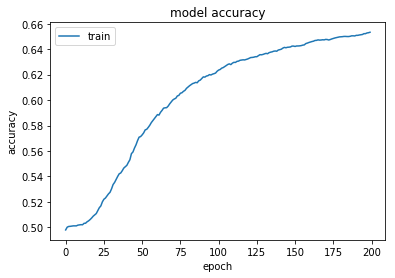

In [18]:
# summarize history for accuracy
plt.plot(acc_df.describe().loc['mean'].values)
#plt.plot(random_network[2].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./data/results/acc_formula_' + str(n) + filename + '.png')
plt.show()

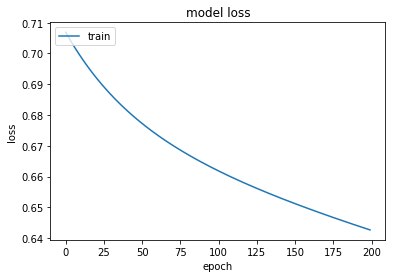

In [19]:
# summarize history for loss
plt.plot(loss_df.describe().loc['mean'].values)
#plt.plot(random_network[2].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./data/results/loss_formula_' + str(n) + filename + '.png')
plt.show()